In [65]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import scanpy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import json
import os
import scanpy as sc
from sklearn.decomposition import PCA
from umap import UMAP
from tqdm import tqdm

# not use the GPU (because I temporarily lack GPU memory)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as keras_preprocess_input

In [60]:
current_folder = globals()['_dh'][0] # for jupyter notebook
image_dir = current_folder / ".." / ".." / "data" / "raw" / "visium"
processed_dir = current_folder / ".." / ".." / "data" / "uscsc_dump" 
tile_out = current_folder / ".." / ".." / "data" / "tiles"
tile_out.mkdir(parents=True, exist_ok=True)
samples = [f for f in os.listdir(image_dir) if not f.startswith(".")]
{i: smp for i, smp in enumerate(samples)}

{0: 'MS197D',
 1: 'MS411',
 2: 'MS466',
 3: 'MS197U',
 4: 'MS229',
 5: 'MS497T',
 6: 'CO96',
 7: 'CO74',
 8: 'MS371',
 9: 'MS377I',
 10: 'MS377T',
 11: 'MS549T',
 12: 'MS497I',
 13: 'CO85',
 14: 'MS94',
 15: 'CO40',
 16: 'MS549H'}

In [71]:
os.listdir(processed_dir)

['visium_MS197D.h5ad',
 'visium_MS94.h5ad',
 'visium_MS497I.h5ad',
 'visium_CO85.h5ad',
 'visium_MS377I.h5ad',
 'visium_MS466.h5ad',
 'visium_MS377T.h5ad',
 'annotated.h5ad',
 'visium_CO74.h5ad',
 'visium_MS411.h5ad',
 'visium_MS229.h5ad',
 'visium_MS197U.h5ad',
 'visium_CO40.h5ad',
 'visium_CO96.h5ad',
 'annotated.zip',
 'visium_MS371.h5ad',
 'visium_MS549H.h5ad',
 'visium_MS549T.h5ad',
 'visium_MS497T.h5ad']

In [38]:
def Read10X(path, quality = "hires"):  # use quality = "lowres" for low resolution images

    adata = scanpy.read_10x_h5(path / "filtered_feature_bc_matrix.h5")

    tissue_positions_file = (
        path / "spatial/tissue_positions.csv"
        if (path / "spatial/tissue_positions.csv").exists()
        else path / "spatial/tissue_positions_list.csv"
    )

    library_id = "id"  # TODO: placeholder for library id
    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}

    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path / "spatial/scalefactors_json.json",
        hires_image=path / "spatial/tissue_hires_image.png",
        lowres_image=path / "spatial/tissue_lowres_image.png",
)

    # check if files exists, continue if images are missing
    adata.uns["spatial"][library_id]["images"] = dict()
    for res in ["hires", "lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        files["scalefactors_json_file"].read_bytes()
    )

    # read coordinates
    positions = pd.read_csv(files["tissue_positions_file"], header=None)
    positions.columns = [
        "barcode",
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    positions.index = positions["barcode"]

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm["spatial"] = (
        adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]]
        .to_numpy()
        .astype(int)
    )
    adata.obs.drop(
        columns=["barcode", "pxl_row_in_fullres", "pxl_col_in_fullres"],
        inplace=True,
    )

    adata.var_names_make_unique()

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    scale = adata.uns["spatial"][library_id]["scalefactors"][
        "tissue_" + quality + "_scalef"
    ]
    image_coor = adata.obsm["spatial"] * scale

    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.uns["spatial"][library_id]["use_quality"] = quality

    adata.obs["array_row"] = adata.obs["array_row"].astype(int)
    adata.obs["array_col"] = adata.obs["array_col"].astype(int)
    adata.obsm["spatial"] = adata.obsm["spatial"].astype("int64")

    return adata

In [54]:
def get_tiles(adata, out_path, crop_size = 40, target_size = 299):

    library_id = list(adata.uns["spatial"].keys())[0]

    out_path.mkdir(parents=True, exist_ok=True)

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)

    if img_pillow.mode == "RGBA":
        img_pillow = img_pillow.convert("RGB")

    tile_names = []

    for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
        imagerow_down = imagerow - crop_size / 2
        imagerow_up = imagerow + crop_size / 2
        imagecol_left = imagecol - crop_size / 2
        imagecol_right = imagecol + crop_size / 2
        tile = img_pillow.crop(
            (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
        )
        tile.thumbnail((target_size, target_size), Image.Resampling.LANCZOS)
        tile.resize((target_size, target_size))
        tile_name = str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)
        out_tile = Path(out_path) / (tile_name + ".jpeg")
        tile_names.append(str(Path(out_path) / (tile_name + ".jpeg")))
        tile.save(out_tile, "JPEG")

    adata.obs["tile_path"] = tile_names

In [55]:
def get_features(adata):

    if not "tile_path" in adata.obs.columns:
        raise ValueError("Please run tiling before extracting features.")

    model = ResNet50(include_top=False, weights="imagenet", pooling="avg")

    features = np.zeros((adata.shape[0], 2048))

    for i, tile_path in enumerate(tqdm(adata.obs.tile_path)):
        tile = Image.open(tile_path)
        tile = np.asarray(tile, dtype="int32")
        tile = tile.astype(np.float32)
        tile = np.stack([tile])
        tile = keras_preprocess_input(tile)
        features[i, :] = model.predict(tile, batch_size=1, verbose=False)

    adata.obsm["image_features"] = features
    pca_coord = PCA(n_components=50).fit_transform(features)
    adata.obsm["image_features_pca"] = pca_coord
    umap_coord = UMAP(n_components=2).fit_transform(pca_coord)
    adata.obsm["image_features_umap"] = umap_coord

In [56]:
adata_test = Read10X(image_dir / samples[0] / "outs")
adata_test

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2880 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [57]:
get_tiles(adata_test, out_path = tile_out / samples[0])
adata_test.obs

,in_tissue,array_row,array_col,imagecol,imagerow,tile_path
AAACACCAATAACTGC-1,1,59,19,615.504352,1493.150670,/home/philipp/Work/VisiumMS/scripts/process/.....
AAACAGCTTTCAGAAG-1,1,43,9,939.912818,1591.220407,/home/philipp/Work/VisiumMS/scripts/process/.....
AAACAGGGTCTATATT-1,1,47,13,858.032370,1549.501853,/home/philipp/Work/VisiumMS/scripts/process/.....
AAACAGTGTTCCTGGG-1,1,73,43,322.540470,1233.188032,/home/philipp/Work/VisiumMS/scripts/process/.....
AAACATTTCCCGGATT-1,1,61,97,529.576582,602.739720,/home/philipp/Work/VisiumMS/scripts/process/.....
...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,621.731003,1229.140710,/home/philipp/Work/VisiumMS/scripts/process/.....
TTGTTTCATTAGTCTA-1,1,60,30,589.041090,1368.306338,/home/philipp/Work/VisiumMS/scripts/process/.....
TTGTTTCCATACAACT-1,1,45,27,889.476953,1387.297620,/home/philipp/Work/VisiumMS/scripts/process/.....
TTGTTTGTATTACACG-1,1,73,41,323.785800,1255.915305,/home/philipp/Work/VisiumMS/scripts/process/.....


In [58]:
get_features(adata_test)

2023-05-30 15:33:33.823631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-30 15:33:33.823666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: CrunchyPeanut
2023-05-30 15:33:33.823671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: CrunchyPeanut
2023-05-30 15:33:33.823727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 495.29.5
2023-05-30 15:33:33.823744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 495.29.5
2023-05-30 15:33:33.823748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 495.29.5


In [61]:
# read the annotated adata object for comparison
adata = sc.read_h5ad(processed_dir / ("visium_" + samples[0] + ".h5ad"))
adata_test.obs = adata_test.obs.join(adata.obs.loc[:, ["leiden"]], how="left")

<Axes: >

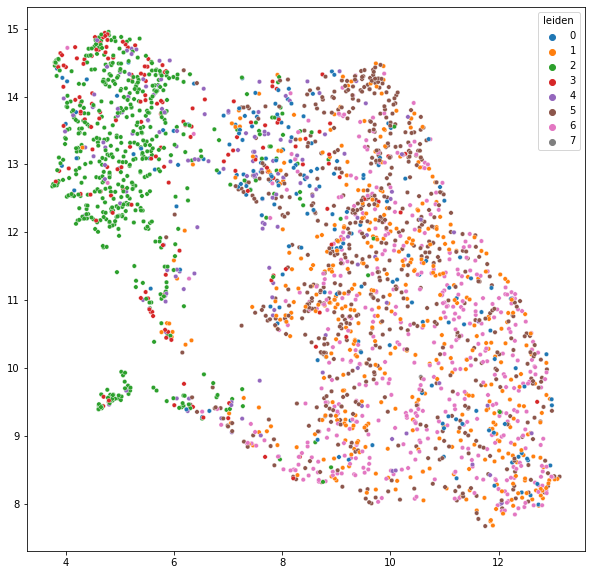

In [70]:
adata_test.obsm["image_features_umap"]

# use seaborn to make scatterplot of adata_test.obsm["image_features_umap"] with 5 x 5 figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=adata_test.obsm["image_features_umap"][:, 0],
    y=adata_test.obsm["image_features_umap"][:, 1],
    hue=adata_test.obs["leiden"],
    s=20)

# save the figure
fig.savefig(out_dir / "image_features_umap.png", dpi=300)